In [133]:
import scipy
import numpy as np
from tools import *
set_seaborn()
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:

def train_test_method(X, Y, model, reg=0, train_test_ratio=0.2, dim=100, plot=False, name=''):

    split = int(len(X) * train_test_ratio)
    X_train, X_test = X[split:], X[:split]
    Y_train, Y_test = Y[split:], Y[:split]

    P_train, theta = model(X_train, Y_train, dim, reg=reg)

    pad_test_sig = np.concatenate([np.zeros(dim - 1), X_test])
    test_Han = build_hankel(pad_test_sig, dim)
    P_test = theta @ test_Han[:len(theta), :]
    P_test = normalize(P_test)

    train_err = mean_square_error(Y_train, P_train)
    test_err = mean_square_error(Y_test, P_test)

    if plot:
        figure(figsize = (8, 8), dpi = 80)
        plt.plot(theta)
        plt.title(f"{name} Fit Eigenvectors")
        plt.show()

        plt.plot(Y_train, label="True");
        plt.plot(P_train, label="Pred");
        plt.title(f"{name} TRAIN Fit Sig"); plt.legend()
        plt.show()

        plt.plot(Y_test, label="True")
        plt.plot(P_test, label="Pred")
        plt.title(f"{name} TEST Fit Sig"); plt.legend()
        plt.show()

        print(f'Train Error: {train_err}')
        print(f'Test Error: {test_err}')

    return train_err, test_err, theta


class Results:
    def __init__(self, model, name):
        self.model = model
        self.name = name
        self.train_errs = []
        self.test_errs = []
        self.filters = []
        self.X = []

    def add_results(self, x, train_test_ratio, res):
        train_err, test_err, theta = res 
        self.train_errs.append(train_err)
        
        self.test_errs.append(test_err)
        self.filters.append(theta)
        self.X.append(x)

    def get_test_opt(self):
        min_i = np.argmin(self.test_errs)
        return self.X[min_i], self.filters[min_i]

    def plt_opt_filter(self):
        reg, f = self.get_test_opt()
        figure(figsize = (8, 8), dpi = 80)
        plt.plot(f)
        plt.title(f"{self.name} BestFit Eigenvector, reg={reg}")
        plt.show()

    def plot_eigs(self, step=1):
        num = len(self.filters[::step])
        r = math.ceil(math.sqrt(num))
        fig, axarr = plt.subplots(r, r)
        fig.set_size_inches(r*5, r*5)
        axs1 = [item for sublist in axarr for item in sublist]
    
        for i,e in list(enumerate(self.filters[::step])):
            axs1[i].plot(e)
            axs1[i].set_title(f'{self.name} Reg={self.X[i*step]}')
            
        plt.show()


In [135]:
from tools import *
from projectors import *

def do_full_experiment(sig, res, dim, dataset='', train_test_ratio=0.2,  regs=np.arange(0,50,0.5), plot_sig=False, plot_eigs=False, plot_train=True, plot_test=True, plot_opt=True):

    # baseline
    ones_train_err, ones_test_err, _ = train_test_method(sig, res, ones_model, dim=dim, train_test_ratio=train_test_ratio, plot=False)

    # run tests
    all_results = [Results(linear_model, f'{dataset} Linear Method'), Results(sia_eig_project, f'{dataset} Left-Eigen-Projection'), Results(DMD_project, f'{dataset} DMD-EigenProj')]#, Results(TLS_DMD_project, f'{dataset} TLS_DMD-EigenProj')]

    for reg in regs:
        for results in all_results:
            r = train_test_method(sig, res, results.model, reg=reg, dim=dim, train_test_ratio=train_test_ratio, plot=False)
            results.add_results(reg, r)

    if plot_sig:
        plt.plot(sig);
        plt.title("Input Signal")
        plt.show();
    if plot_test:
        for result in all_results:
            plt.plot(regs, result.test_errs, label=f'{result.name} Error')

        plt.plot(regs, [ones_test_err]*len(regs), label='Ones Error')
        plt.xlabel('Regularization'); plt.ylabel('Error');
        plt.legend(); plt.title(f"{dataset} Regularization vs Test Error"); plt.show();

    if plot_train:
        for result in all_results:
            plt.plot(regs, result.train_errs, label=f'{result.name} Error')

        plt.plot(regs, [ones_test_err]*len(regs), label='Ones Error')
        plt.xlabel('Regularization'); plt.ylabel('Error');
        plt.legend(); plt.title(f"{dataset} Regularization vs Train Error"); plt.show();

    for result in all_results:
        if plot_opt:
            reg, filt = result.get_test_opt()
            train_test_method(sig, res, result.model, reg=reg, dim=dim, train_test_ratio=train_test_ratio, plot=True, name=result.name)
        if plot_eigs:
            result.plot_eigs(step=4)

    return all_results


In [179]:
from tools import *
from projectors import *

def build_train_test_hankels(X, Y, dim, test_start, train_test_ratio, zero_pad):

    start = int(len(X) * test_start)
    end = start + int(len(X) * train_test_ratio)
    X_test, Y_test = X[start:end],  Y[start:end]
    X_train, Y_train = X.copy(), Y.copy()
    # use to remove from hankel later
    X_train[start:end] = np.nan
    
    if zero_pad:
        X_test = np.concatenate([np.zeros(dim), X_test])
        X_train = np.concatenate([np.zeros(dim), X_train])
    else:
        # remove the beginning if not zero padding
        Y_train = np.delete(Y_train, np.arange(0,dim))
        Y_test = np.delete(Y_test, np.arange(0,dim))

    test_hankel = build_hankel(X_test, dim)
    train_hankel = build_hankel(X_train, dim)

    # remove lag vector with nan
    nan_cols = np.bitwise_or.reduce(np.isnan(train_hankel),0)
    # print(np.count_nonzero(nan_cols))

    train_hankel = np.delete(train_hankel, nan_cols, axis=1)
    Y_train = np.delete(Y_train, nan_cols)

    return train_hankel, Y_train, test_hankel, Y_test

def train_test_method_multi(X, Y, model, test_start, dim, train_test_ratio, reg, zero_pad):

    train_hankel, Y_train, test_hankel, Y_test = build_train_test_hankels(X, Y, dim, test_start, train_test_ratio, zero_pad)
    P_train, theta = model(train_hankel, Y_train, dim, reg=reg)
    
    P_test = theta @ test_hankel
    P_test = normalize(P_test)

    train_err = mean_square_error(Y_train, P_train)
    test_err = mean_square_error(Y_test, P_test)

    # if reg==0 or reg==5:
    #     # [plt.plot(np.arange(i,i+len(h)),h) for i,h in enumerate(train_hankel.T)]
    #     # plt.show()
    #     # plt.plot(X_train)
    #     # plt.plot(X_test)
    #     # plt.title('X')
    #     # plt.show()
    #     # plt.plot(Y)
    #     plt.plot(Y_test)
    #     plt.plot(P_test)
    #     plt.title(reg)
    #     plt.show()
    #     plt.plot(theta)
    #     plt.show()

    return train_err, test_err, theta

def do_full_experiment_multiple(sig, res, model, dim, train_test_ratio=0.5, regs=np.arange(0,30,1), zero_pad=False):

    test_start_range = np.linspace(0.0,1.0-train_test_ratio,100)
    T = len(test_start_range)
    R = len(regs)

    train_errors = np.zeros((R,T))
    test_errors = np.zeros((R,T))
    filters = np.zeros((R,T,dim))
    for t, test_start in enumerate(test_start_range):
        for r, reg in enumerate(regs):
            
            train_err, test_err, theta = train_test_method_multi(sig, res, model, test_start, dim, train_test_ratio, reg, zero_pad)
            train_errors[r,t] = train_err
            test_errors[r,t] = test_err
            filters[r,t,:] = theta

    return train_errors, test_errors, filters, regs



def get_opt_mean_and_stds(train_errors, test_errors, filters, regs):
    avg_train_errors, std_train_errors = np.mean(train_errors, axis=1), np.std(train_errors, axis=1)
    avg_test_errors, std_test_errors = np.mean(test_errors, axis=1), np.std(test_errors, axis=1)

    opt_i = np.argmin(avg_test_errors)
    opt_filters = filters[opt_i]
    opt_reg = regs[opt_i]
    avg_filters, std_filters = np.mean(opt_filters, axis=0), np.std(opt_filters, axis=0)

    return (avg_train_errors, std_train_errors),  (avg_test_errors, std_test_errors), (avg_filters, std_filters), opt_reg


In [180]:
downsample = 10
resPH, stimPH = read_lmc('PHOTO', pre_process=True, downsample=downsample)
res3, stim3 = read_lmc('LMC-BG3', pre_process=True, downsample=downsample)
res4, stim4 = read_lmc('LMC-BG4', pre_process=True, downsample=downsample)
res5, stim5 = read_lmc('LMC-BG5', pre_process=True, downsample=downsample)
res6, stim6 = read_lmc('LMC-BG6', pre_process=True, downsample=downsample)


In [181]:
title = 'LMC-BG4'
X, Y = resPH.copy()*-1, res4.copy()
dim = 50

model = ones_model
train_errors, test_errors, ones_filters, regs = do_full_experiment_multiple(X, Y, model, dim=dim)
ones_train, ones_test, ones_filt, ones_optreg = get_opt_mean_and_stds(train_errors, test_errors, ones_filters, regs)

model = sia_eig_project
train_errors, test_errors, eig_filters, regs = do_full_experiment_multiple(X, Y, model, dim=dim)
eig_train, eig_test, eig_filt4, eig_optreg = get_opt_mean_and_stds(train_errors, test_errors, eig_filters, regs)

model = linear_model
train_errors, test_errors, lin_filters, regs = do_full_experiment_multiple(X, Y, model, dim=dim)
lin_train, lin_test, lin_filt, lin_optreg = get_opt_mean_and_stds(train_errors, test_errors, lin_filters, regs)



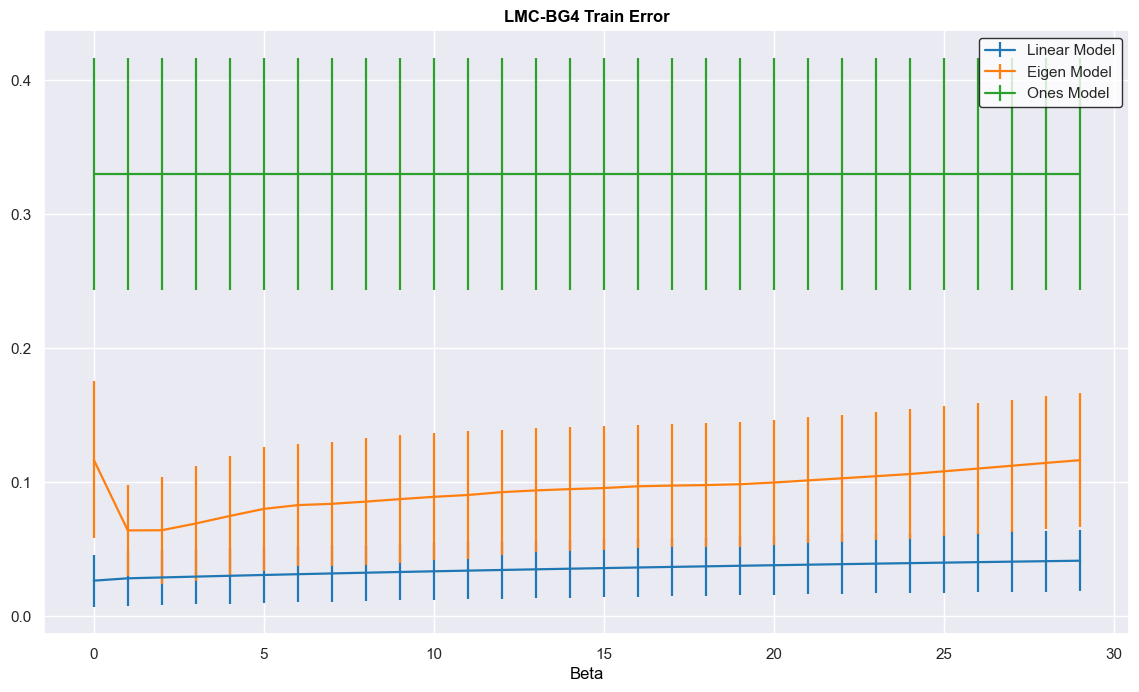

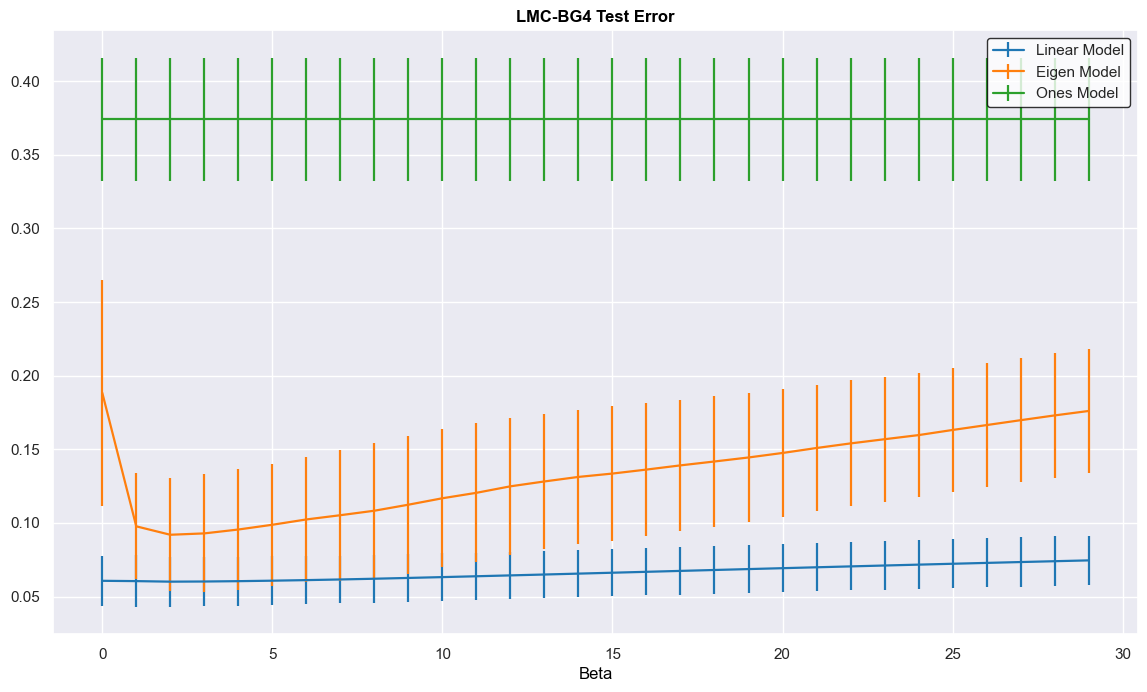

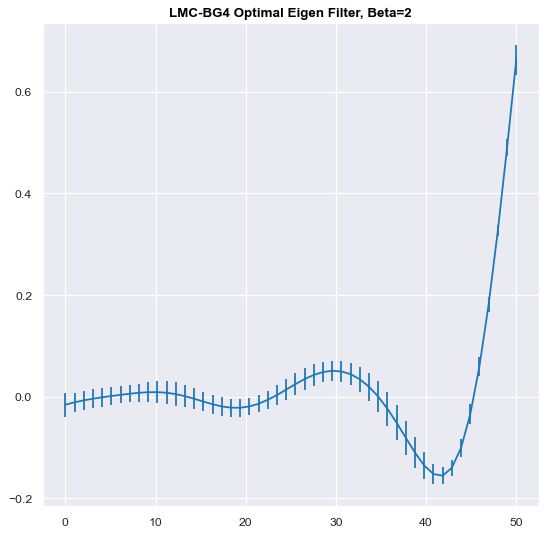

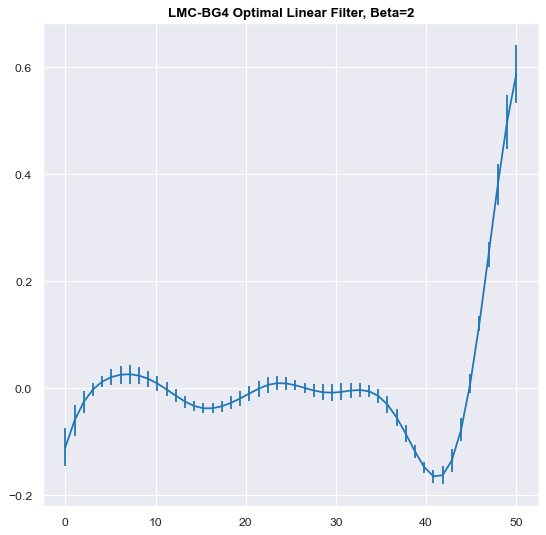

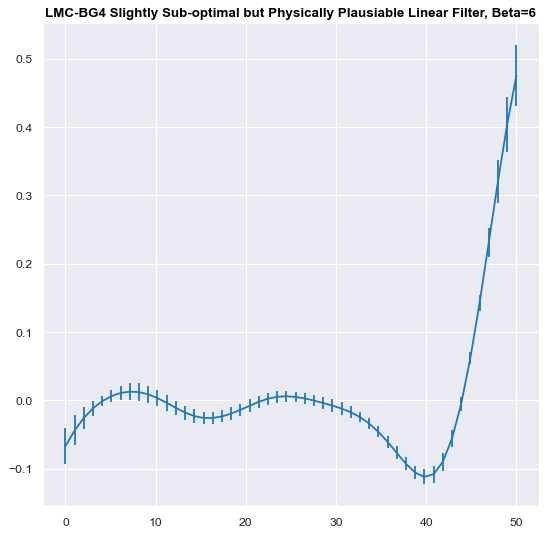

In [182]:

plt.errorbar(regs, *lin_train, label='Linear Model')
plt.errorbar(regs, *eig_train, label='Eigen Model')
plt.errorbar(regs, *ones_train, label='Ones Model')
plt.legend(); plt.xlabel('Beta'); plt.title(f'{title} Train Error')
plt.show()


plt.errorbar(regs, *lin_test, label='Linear Model')
plt.errorbar(regs, *eig_test, label='Eigen Model')
plt.errorbar(regs, *ones_test, label='Ones Model')
plt.legend(); plt.xlabel('Beta'); plt.title(f'{title} Test Error')
plt.show()

figure(figsize = (8, 8), dpi = 80)
plt.errorbar(np.linspace(0,dim,dim), *eig_filt4)
plt.title(f'{title} Optimal Eigen Filter, Beta={eig_optreg}')
plt.show()

figure(figsize = (8, 8), dpi = 80)
plt.errorbar(np.linspace(0,dim,dim), *lin_filt)
plt.title(f'{title} Optimal Linear Filter, Beta={lin_optreg}')
plt.show()

i = 6
figure(figsize = (8, 8), dpi = 80)
plt.errorbar(np.linspace(0,dim,dim), np.mean(lin_filters[i], axis=0), np.std(lin_filters[i], axis=0))
plt.title(f'{title} Slightly Sub-optimal but Physically Plausiable Linear Filter, Beta={regs[6]}')
plt.show()


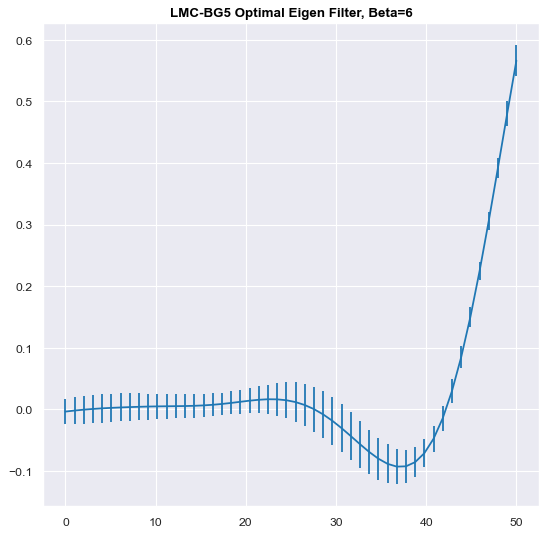

In [183]:
title = 'LMC-BG5'
X, Y = resPH.copy()*-1, res5.copy()
dim = 50

model = sia_eig_project
train_errors, test_errors, eig_filters, regs = do_full_experiment_multiple(X, Y, model, dim=dim)
eig_train, eig_test, eig_filt5, eig_optreg = get_opt_mean_and_stds(train_errors, test_errors, eig_filters, regs)

figure(figsize = (8, 8), dpi = 80)
plt.errorbar(np.linspace(0,dim,dim), *eig_filt5)
plt.title(f'{title} Optimal Eigen Filter, Beta={eig_optreg}')
plt.show()

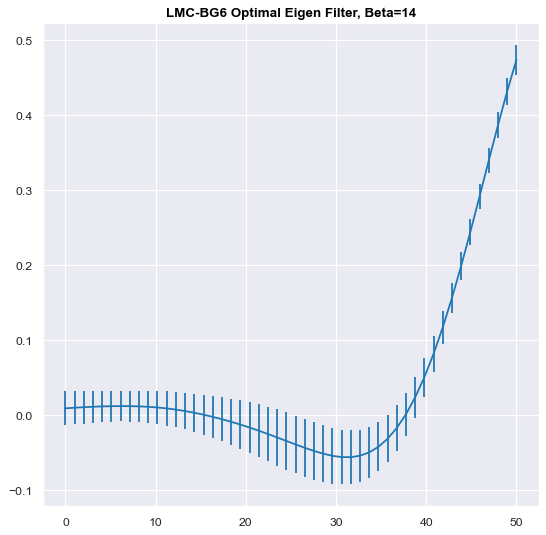

In [184]:
title = 'LMC-BG6'
X, Y = resPH.copy()*-1, res6.copy()
dim = 50

model = sia_eig_project
train_errors, test_errors, eig_filters, regs = do_full_experiment_multiple(X, Y, model, dim=dim)
eig_train, eig_test, eig_filt6, eig_optreg = get_opt_mean_and_stds(train_errors, test_errors, eig_filters, regs)

figure(figsize = (8, 8), dpi = 80)
plt.errorbar(np.linspace(0,dim,dim), *eig_filt6)
plt.title(f'{title} Optimal Eigen Filter, Beta={eig_optreg}')
plt.show()

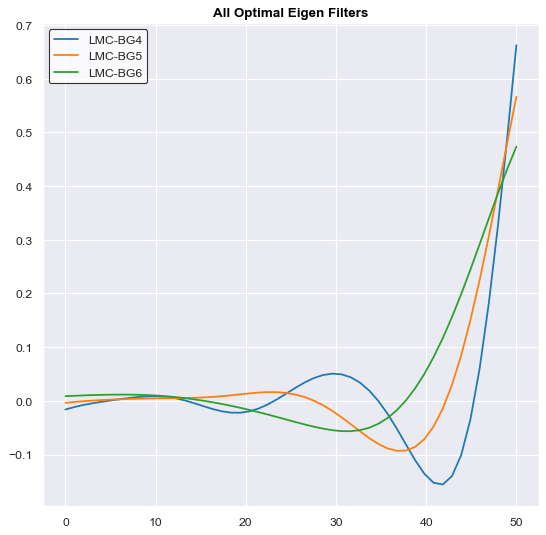

In [185]:
figure(figsize = (8, 8), dpi = 80)
plt.title(f'All Optimal Eigen Filters')
for i,ef in enumerate([eig_filt4, eig_filt5, eig_filt6]):
    plt.plot(np.linspace(0,dim,dim), ef[0], label=f'LMC-BG{i+4}')

plt.legend()
plt.show()